In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,095 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [6]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [7]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

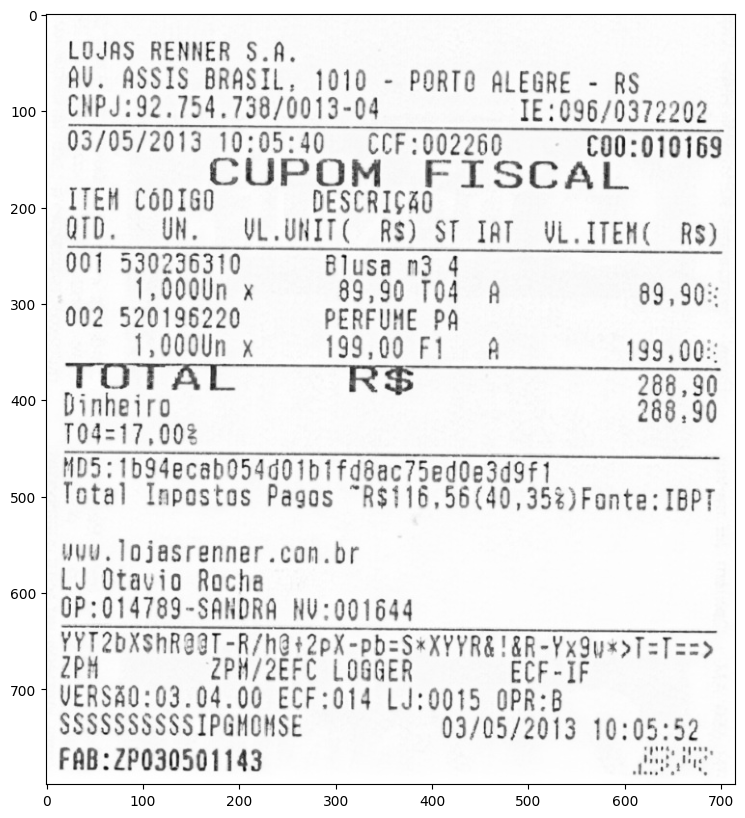

In [8]:
file_name = "/content/Cupom.jpg"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

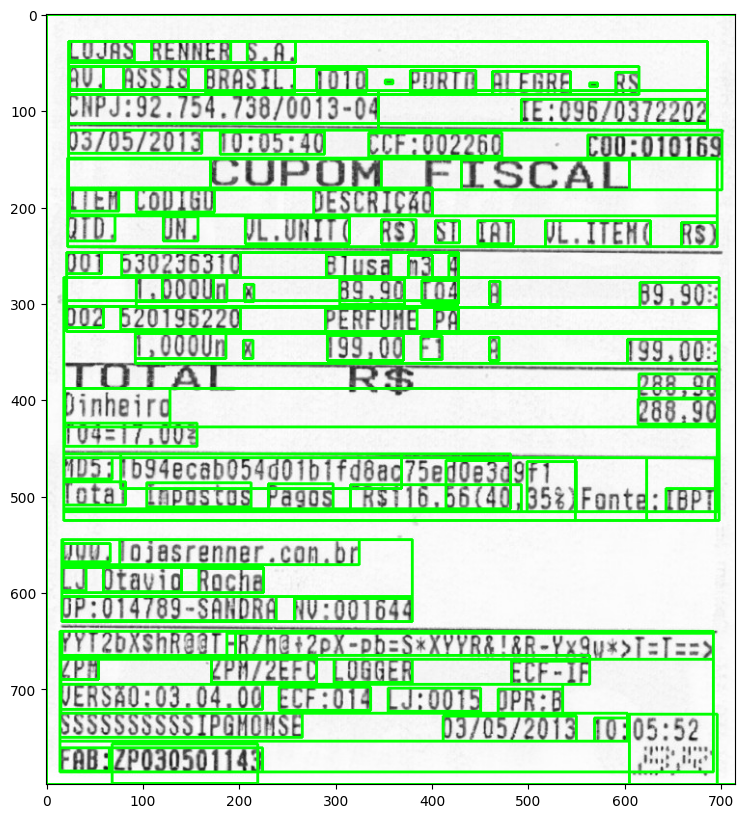

In [9]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

In [10]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

LOJAS RENNER S.A.
AU. ASSIS BRASIL, 1010 - PORTG ALEGRE - RS
CHPJ:92.754.738/0013-04 TE:096/0372202

03/05/2013 10:05:40 CCF:002260 €00:010169
ISCAL

CUPOM
ITEM CODIGO DESCRICAO
QrD. UN. VL.UNIT( RS) ST IAT UL.ITEN( Rs)

001 530236310 Blusa m3 4
000U

1,000Un x 89,90 T04 A 89,90:
002 520196220 PERFUME PA

1,000Un x 199,00 Fl A 199,00:

288,90

Dinheiro 288.90
T04=17,008
MDS: 1b94ecab054d01bifd8ac ghana
Total Impostos Pagos ~R$i16,56(40, 344) Fonte: IBPT

uuu. lojasrenner.con.br
LJ Otavio Rocha
OP:014789-SANDRA NV:001644

YYT2DXSHRGGT -R/HG+2pX-pb=S*XVYRG!8R-Vx9uxoT=1==>
2PH ZPH/2EFC LOGGER ECF-IF
VERSKO:03.04.00 ECF:014 LJ:0015 OPR:B
SSSSSSSSSSIPGHONSE 03/05/2013 10:
FAB: 2P030501143

 



In [11]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [12]:
amounts = find_amounts(extracted_text)
amounts

[288.9, 3.04]

In [13]:
max(amounts)

288.9

In [58]:
def extract_data(image):
  # Extract text using Tesseract
  text = pytesseract.image_to_string(image, output_type=Output.DICT)

  # Define empty dictionary to store data
  data = {}

  # Extract store name and address (assuming it's in the first few lines)
  lines = text['text'].splitlines()
  data['loja'] = lines[0]  # Assuming store name is in the first line
  data['endereco'] = lines[1]  # Assuming address is in the second line
  data['cnpj'] = lines[2]


  # Extract attendant using regular expression
  attendant_regex = r"LJ (\w+ )+\w+\w+"
  attendant_match = re.search(attendant_regex, text['text'])
  if attendant_match:
      data['atendente'] = attendant_match.group()

  # Extract items using regular expressions (you might need to adjust these)
  items = []
  item_regex = r"\d{3} (.*?) \d+\.\d{2}"  # Capture item details (code, description, price)
  for item_match in re.finditer(item_regex, text['text']):
      item = {
          "codigo": item_match.group(1).split()[0],  # Extract code
          "descricao": " ".join(item_match.group(1).split()[1:]),  # Extract description
          "preco": float(item_match.group(2).replace(",", "."))  # Extract price
      }
      items.append(item)
  data['itens'] = items

  # You can add more logic to extract other details like total amount, payment method, etc.
  # based on the structure of your cupom fiscal.

  return data

In [17]:
import json

In [59]:
data = extract_data(image)

# Save data to JSON file
with open('cupom_fiscal_data.json', 'w') as outfile:
  json.dump(data, outfile, indent=4)

print("Extracted data saved to cupom_fiscal_data.json")

Extracted data saved to cupom_fiscal_data.json
